In [ ]:
!pip install yfinance

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf
import itertools
import math
from co import *
import ndtest
import random
from h1 import *

In [5]:
def metrics_calc(cumret):
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [6]:
#sp500 ticker download
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

x=save_sp500_tickers()

for i in range (0,len(x)):
    x[i]=x[i].replace('\n', '')
x.remove('BRK.B')
x.remove('BF.B')
x.remove('ZTS')
x.remove('ZION')
x.remove('ZBH')
x.remove('ZBRA')
asset_list=x

In [7]:
#Asset list
lst=asset_list[250:300]

#dates for model calibration
start_data='2021-08-19'
end_data='2022-08-19'

#dates for trading with algo
start_trade='2022-03-01'
end_trade='2022-09-01'

index_comp='SPY'

#number of desired trading pairs 
n=int(len(lst)/2)

In [7]:
#randomly select pairs from basket of assets
selected_pairs=[]
lst2=lst.copy()
while len(lst2)>0:
    ran_choice1=random.choice(lst2)
    lst2.remove(ran_choice1)
    ran_choice2=random.choice(lst2)
    lst2.remove(ran_choice2)
    selected_pairs.append(tuple((ran_choice1,ran_choice2)))
selected_pairs

[('JNJ', 'INTU'),
 ('J', 'LYB'),
 ('ISRG', 'MPC'),
 ('L', 'JPM'),
 ('KHC', 'KIM'),
 ('JCI', 'LW'),
 ('MKTX', 'IP'),
 ('K', 'LH'),
 ('KR', 'IQV'),
 ('KDP', 'MAR'),
 ('LYV', 'MMC'),
 ('LIN', 'LEN'),
 ('MAS', 'LMT'),
 ('IFF', 'LKQ'),
 ('JNPR', 'KLAC'),
 ('IVZ', 'LOW'),
 ('LRCX', 'KMB'),
 ('LHX', 'MA'),
 ('MTB', 'KMI'),
 ('MRO', 'LUMN'),
 ('LNC', 'KEYS'),
 ('IRM', 'JBHT'),
 ('KEY', 'IPG'),
 ('LVS', 'MLM'),
 ('LDOS', 'JKHY')]

In [8]:
df=pd.DataFrame()
best_cop_lst=[]

algo_returns = {}
cl = 0.99

for i in range(0,len(selected_pairs)):
    #assets (yfinance ticker)
    asset1=selected_pairs[i][0]
    asset2=selected_pairs[i][1]
    pairs=selected_pairs[i] #insert name of asset 1 and asset 2

    #fetch log returns of pair (to model calibration)

    X = yf.download(asset1, start = start_data, end=end_data)
    X.reset_index(inplace=True)
    X.tail()
    X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
    x = X['Log_Returns'].drop(labels=0, axis=0).dropna()
    date=X['Date'].drop(labels=0,axis=0)
    date=date.to_frame()




    Y = yf.download(asset2, start = start_data, end=end_data)
    Y.reset_index(inplace=True)
    Y.tail()
    Y['Log_Returns'] = np.log(Y['Adj Close']) - np.log(Y['Adj Close'].shift(1))
    y = Y['Log_Returns'].drop(labels=0, axis=0).dropna()

    #fit distribution to element in pair + probability integral transform to get marginal uniform

    param1 = stats.t.fit(x)
    dist1=stats.t(*param1)
    u=dist1.cdf(x)
    param2=stats.t.fit(y)
    dist2=stats.t(*param2)
    v=dist2.cdf(y)



    #put returns in a data frame with corresponding dates
    x_df=x.to_frame()
    y_df=y.to_frame()

    a=y_df.rename(columns={'Log_Returns': asset2})
    b=x_df.rename(columns={'Log_Returns': asset1})

    p =a.join(b)
    x=p.join(date)

    returns_df=x.set_index('Date')


    #fit bivariate copula family to data 
    #calculate Akaike information criterion, Bayesion information criterion and KS value to help determine good fit

    pair=[pairs]
    copulas_df = pd.DataFrame(index=pair, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])


    best_aic = np.inf
    best_copula= None


    copulas=[GaussianCopula(),GumbelCopula(), ClaytonCopula(),FrankCopula()]
    for copula in copulas:
        copula.fit(u,v)

        L = copula.log_likelihood(u,v)
        aic = 2 * copula.num_params - 2 * L
        if aic < best_aic:
            best_aic = aic
            best_bic = copula.num_params * np.log(len(u)) - 2 * L
            best_copula = copula

            # calculate KS-pvalue
            smp = copula.sample(size=len(u)) # generate sample from fit copula
            s_u = smp[:,0]
            s_v = smp[:,1]
            ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)

            if isinstance(copula, ArchimedeanCopula):
                best_param = copula.alpha
            else:
                best_param = copula.rho
    
    best_cop_lst.append(best_copula)
    copulas_df.loc[pair] = [best_copula.name, best_param, best_aic, best_bic, ks_pval]
    df=df.append(copulas_df)
print('Best fit copulas for randomly generated pairs')
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/content/co.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

/content/co.py:322: RuntimeWarning: invalid value encountered in power
  num = (u**(-alpha) * v**(-alpha) * (alpha+1) * (-1 + v**(-alpha) + u**(-alpha))**(-1/alpha))



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

/content/co.py:28: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(u,v)).sum()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Best fit copulas for randomly generated pairs


,copula,parameter,aic,bic,KS_pvalue
"(JNJ, INTU)",Gaussian,0.189053,-81.346413,-77.82096,0.463278
"(J, LYB)",Gaussian,0.477844,-159.714181,-156.188728,0.29034
"(ISRG, MPC)",Gaussian,0.20525,-87.24754,-83.722087,0.803513
"(L, JPM)",Gaussian,0.753357,-248.746365,-245.220912,0.547762
"(KHC, KIM)",Gaussian,0.320236,-123.245678,-119.720225,0.050755
"(JCI, LW)",Gaussian,0.438961,-151.534752,-148.009299,0.157035
"(MKTX, IP)",Gaussian,0.31406,-121.546854,-118.021401,0.609085
"(K, LH)",Gaussian,0.169549,-73.964839,-70.439386,0.383193
"(KR, IQV)",Gaussian,0.071533,-32.455934,-28.930481,0.359658
"(KDP, MAR)",Gaussian,0.265056,-107.198321,-103.672869,0.048699


In [ ]:
algo_returns = {}
cl = 0.90
for i in range(0,n): 

#dataframe of the returns for the specific trading period for each pair

    X_trade = yf.download(selected_pairs[i][0], start =start_trade, end=end_trade)
    X_trade.reset_index(inplace=True)
    X_trade['Log_Returns'] = np.log(X_trade['Adj Close']) - np.log(X_trade['Adj Close'].shift(1))
    x_trade = X_trade['Log_Returns'].drop(labels=0, axis=0).dropna()
    date=X_trade['Date'].drop(labels=0,axis=0)
    date=date.to_frame()


    Y_trade = yf.download(selected_pairs[i][1], start = start_trade, end=end_trade)
    Y_trade.reset_index(inplace=True)
    Y_trade.tail()
    Y_trade['Log_Returns'] = np.log(Y_trade['Adj Close']) - np.log(Y_trade['Adj Close'].shift(1))
    y_trade = Y_trade['Log_Returns'].drop(labels=0, axis=0).dropna()

    #put returns in a data frame with corresponding dates
    x2_df=x_trade.to_frame()
    y2_df=y_trade.to_frame()


    a=x2_df.rename(columns={'Log_Returns': selected_pairs[i][0]})
    m=y2_df.rename(columns={'Log_Returns': selected_pairs[i][1]})


    p =m.join(a)
    x=p.join(date)

    returns_trade_period=x.set_index('Date')
    u1= dist1.cdf(returns_trade_period[selected_pairs[i][0]])
    v1= dist2.cdf(returns_trade_period[selected_pairs[i][1]])
    
        # calculate conditional probabilities
    prob1=[]
    prob2=[]

    for u,v in zip(u1, v1):
        prob1.append(best_cop_lst[i].cdf_u_given_v(u,v))
        prob2.append(best_cop_lst[i].cdf_v_given_u(u,v))


    probs_trade= pd.DataFrame(np.vstack([prob1,prob2]).T,index=returns_trade_period.index, columns=[selected_pairs[i][0],selected_pairs[i][1]])

    

    #calculate positions
    positions=pd.DataFrame(index=probs_trade.index, columns = probs_trade.columns)
    long = False
    short = False


    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][selected_pairs[i][0]] > 0.5) or (probs_trade.loc[t][selected_pairs[i][1]] < 0.5):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][selected_pairs[i][0]] < 0.5) or (probs_trade.loc[t][selected_pairs[i][1]] > 0.5):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][selected_pairs[i][0]] < (1-cl)) and (probs_trade.loc[t][selected_pairs[i][1]] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][selected_pairs[i][0]] > cl) and (probs_trade.loc[t][selected_pairs[i][1]] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]


    # calculate returns
    algo_ret = (returns_trade_period * positions.shift()).sum(axis=1)
    algo_returns[selected_pairs[i]] = algo_ret

rets = pd.DataFrame.from_dict(algo_returns)
rets = np.exp(rets) - 1 # convert log-returns to simple returns
total_ret = rets.sum(axis=1) / len(rets.columns) * 2 # double capital (from short positions)



In [ ]:
hrst=Hurst1()
h=hrst.get_hurst_return(lst=lst,start_data=start_data,
                        end_data=end_data,start_trade=start_trade,end_trade=end_trade,n=n)





In [13]:
index_price = yf.download(index_comp, start=start_trade, end=end_trade)
index_price = index_price['Adj Close']
index_ret = index_price.pct_change().dropna()


metrics= pd.DataFrame(index=['Algo-Hurst','Algo-Random'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Drawdown Duration'])
metrics.loc['Algo-Hurst'] = metrics_calc(np.nancumprod(h + 1))
metrics.loc['Algo-Random'] = metrics_calc(np.nancumprod(total_ret+ 1))
metrics.loc['Index']=metrics_calc(np.nancumprod(index_ret + 1))
metrics


[*********************100%***********************]  1 of 1 completed


,Total return,APR,Sharpe,Max Drawdown,Max Drawdown Duration
Algo-Hurst,0.010771,0.021149,1.199415,-0.007704,42.0
Algo-Random,0.237365,0.515981,4.710016,-0.038784,15.0
Index,-0.090822,-0.172155,-0.641352,-0.205611,107.0


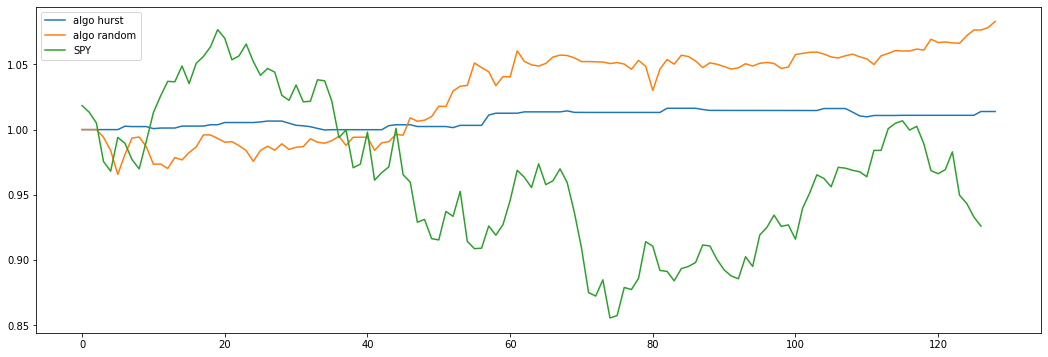

In [12]:
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(h + 1), label='algo hurst')
plt.plot(np.nancumprod(total_ret + 1), label='algo random')
plt.plot(np.nancumprod(index_ret + 1), label=index_comp)
plt.legend()

In [ ]:
#monte carlo random pairs -> take average of total returns/sharpe etc of simulations
# s= math.comb((len(lst)),2)#number of Monte Carlo simulation
s=4
t_r_list=[]
apr_list=[]
sharpe_list=[]
mdd_list=[]
mddd_list=[]

for mc in range(0,s):
    selected_pairs=[]

    lst2=lst.copy()
    while len(lst2)>0:
        ran_choice1=random.choice(lst2)
        lst2.remove(ran_choice1)
        ran_choice2=random.choice(lst2)
        lst2.remove(ran_choice2)
        selected_pairs.append(tuple((ran_choice1,ran_choice2)))


    df=pd.DataFrame()
    best_cop_lst=[]

    algo_returns = {}
    cl = 0.99

    for i in range(0,len(selected_pairs)):
        #assets (yfinance ticker)
        asset1=selected_pairs[i][0]
        asset2=selected_pairs[i][1]
        pairs=selected_pairs[i] #insert name of asset 1 and asset 2

        #fetch log returns of pair (to model calibration)

        X = yf.download(asset1, start = start_data, end=end_data)
        X.reset_index(inplace=True)
        X.tail()
        X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
        x = X['Log_Returns'].drop(labels=0, axis=0).dropna()
        date=X['Date'].drop(labels=0,axis=0)
        date=date.to_frame()




        Y = yf.download(asset2, start = start_data, end=end_data)
        Y.reset_index(inplace=True)
        Y.tail()
        Y['Log_Returns'] = np.log(Y['Adj Close']) - np.log(Y['Adj Close'].shift(1))
        y = Y['Log_Returns'].drop(labels=0, axis=0).dropna()

        #fit distribution to element in pair + probability integral transform to get marginal uniform

        param1 = stats.t.fit(x)
        dist1=stats.t(*param1)
        u=dist1.cdf(x)
        param2=stats.t.fit(y)
        dist2=stats.t(*param2)
        v=dist2.cdf(y)



        #put returns in a data frame with corresponding dates
        x_df=x.to_frame()
        y_df=y.to_frame()

        a=y_df.rename(columns={'Log_Returns': asset2})
        b=x_df.rename(columns={'Log_Returns': asset1})

        p =a.join(b)
        x=p.join(date)

        returns_df=x.set_index('Date')


        #fit bivariate copula family to data 
        #calculate Akaike information criterion, Bayesion information criterion and KS value to help determine good fit

        pair=[pairs]
        copulas_df = pd.DataFrame(index=pair, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])


        best_aic = np.inf
        best_copula= None


        copulas=[GaussianCopula(),GumbelCopula(), ClaytonCopula(),FrankCopula()]
        for copula in copulas:
            copula.fit(u,v)

            L = copula.log_likelihood(u,v)
            aic = 2 * copula.num_params - 2 * L
            if aic < best_aic:
                best_aic = aic
                best_bic = copula.num_params * np.log(len(u)) - 2 * L
                best_copula = copula

                # calculate KS-pvalue
                smp = copula.sample(size=len(u)) # generate sample from fit copula
                s_u = smp[:,0]
                s_v = smp[:,1]
                ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)

                if isinstance(copula, ArchimedeanCopula):
                    best_param = copula.alpha
                else:
                    best_param = copula.rho

        best_cop_lst.append(best_copula)
        copulas_df.loc[pair] = [best_copula.name, best_param, best_aic, best_bic, ks_pval]
        df=df.append(copulas_df)

    algo_returns = {}
    cl = 0.90
    for i in range(0,n): 

#dataframe of the returns for the specific trading period for each pair

        X_trade = yf.download(selected_pairs[i][0], start =start_trade, end=end_trade)
        X_trade.reset_index(inplace=True)
        X_trade['Log_Returns'] = np.log(X_trade['Adj Close']) - np.log(X_trade['Adj Close'].shift(1))
        x_trade = X_trade['Log_Returns'].drop(labels=0, axis=0).dropna()
        date=X_trade['Date'].drop(labels=0,axis=0)
        date=date.to_frame()


        Y_trade = yf.download(selected_pairs[i][1], start = start_trade, end=end_trade)
        Y_trade.reset_index(inplace=True)
        Y_trade.tail()
        Y_trade['Log_Returns'] = np.log(Y_trade['Adj Close']) - np.log(Y_trade['Adj Close'].shift(1))
        y_trade = Y_trade['Log_Returns'].drop(labels=0, axis=0).dropna()

        #put returns in a data frame with corresponding dates
        x2_df=x_trade.to_frame()
        y2_df=y_trade.to_frame()


        a=x2_df.rename(columns={'Log_Returns': selected_pairs[i][0]})
        m=y2_df.rename(columns={'Log_Returns': selected_pairs[i][1]})


        p =m.join(a)
        x=p.join(date)

        returns_trade_period=x.set_index('Date')
        u1= dist1.cdf(returns_trade_period[selected_pairs[i][0]])
        v1= dist2.cdf(returns_trade_period[selected_pairs[i][1]])

            # calculate conditional probabilities
        prob1=[]
        prob2=[]

        for u,v in zip(u1, v1):
            prob1.append(best_cop_lst[i].cdf_u_given_v(u,v))
            prob2.append(best_cop_lst[i].cdf_v_given_u(u,v))


        probs_trade= pd.DataFrame(np.vstack([prob1,prob2]).T,index=returns_trade_period.index, columns=[selected_pairs[i][0],selected_pairs[i][1]])



        #calculate positions
        positions=pd.DataFrame(index=probs_trade.index, columns = probs_trade.columns)
        long = False
        short = False


        for t in positions.index:    
            # if long position is open
            if long:
                if (probs_trade.loc[t][selected_pairs[i][0]] > 0.5) or (probs_trade.loc[t][selected_pairs[i][1]] < 0.5):
                    positions.loc[t] = [0,0]
                    long = False
                else:
                    positions.loc[t] = [1,-1]

            # if short position is open
            elif short:
                if (probs_trade.loc[t][selected_pairs[i][0]] < 0.5) or (probs_trade.loc[t][selected_pairs[i][1]] > 0.5):
                    positions.loc[t] = [0,0]
                    short = False
                else:
                    positions.loc[t] = [-1,1]

            # if no positions are open
            else:
                if (probs_trade.loc[t][selected_pairs[i][0]] < (1-cl)) and (probs_trade.loc[t][selected_pairs[i][1]] > cl):
                    # open long position
                    positions.loc[t] = [1,-1]
                    long = True
                elif (probs_trade.loc[t][selected_pairs[i][0]] > cl) and (probs_trade.loc[t][selected_pairs[i][1]] < (1-cl)):
                    # open short positions
                    positions.loc[t] = [-1,1]
                    short = True
                else:
                    positions.loc[t] = [0,0]


        # calculate returns
        algo_ret = (returns_trade_period * positions.shift()).sum(axis=1)
        algo_returns[selected_pairs[i]] = algo_ret

    rets = pd.DataFrame.from_dict(algo_returns)
    rets = np.exp(rets) - 1 # convert log-returns to simple returns
    total_ret = rets.sum(axis=1) / len(rets.columns) * 2 # double capital (from short positions)
    tr,apr,sharpe,mdd,mddd = metrics_calc(np.nancumprod(total_ret+ 1))
    t_r_list.append(tr)
    apr_list.append(apr)
    sharpe_list.append(sharpe)
    mdd_list.append(mdd)
    mddd_list.append(mddd)

import statistics
tr=statistics.mean(t_r_list)
apr=statistics.mean(apr_list)
sharpe=statistics.mean(sharpe_list)
mdd=statistics.mean(mdd_list)
mddd=statistics.mean(mddd_list)
dfret = pd.DataFrame(index=['Algo-Random'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Drawdown Duration'])
dfret.loc['Algo-Random'] = [tr,apr,sharpe,mdd,mddd]
dfret



In [14]:
metrics2= pd.DataFrame(index=['Algo-Hurst','Algo-Random-MC'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Drawdown Duration'])
metrics2.loc['Algo-Hurst'] = metrics_calc(np.nancumprod(h + 1))
metrics2.loc['Algo-Random-MC'] = [tr,apr,sharpe,mdd,mddd]
metrics2.loc['Index']=metrics_calc(np.nancumprod(index_ret + 1))
metrics2

,Total return,APR,Sharpe,Max Drawdown,Max Drawdown Duration
Algo-Hurst,0.010771,0.021149,1.199415,-0.007704,42.0
Algo-Random-MC,0.16352,0.346893,3.430998,-0.035428,21.25
Index,-0.090822,-0.172155,-0.641352,-0.205611,107.0
